## Wave VGG19

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
from sklearn.model_selection import train_test_split
import time
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
%matplotlib inline
from tqdm import tqdm
import numpy as np

In [ ]:
from fastai import * 
from fastai.vision import  * 
%reload_ext autoreload
%autoreload 2
BATCH_SIZE = 64 
IMG_SIZE = 224
WORKERS = 0 
DATA_PATH_STR = './drive/MyDrive/뇌 및 머신러닝/wave/'
DATA_PATH_OBJ = Path(DATA_PATH_STR)
tfms = get_transforms() 

data_spiral = (ImageList.from_folder(DATA_PATH_OBJ)        
        .split_by_rand_pct()                        
        .label_from_folder()                          
        .transform(tfms, size=IMG_SIZE)                  
        .databunch(bs=BATCH_SIZE, num_workers=WORKERS)   
        .normalize(imagenet_stats))
data_spiral.classes

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

['healthy', 'parkinson']

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpola

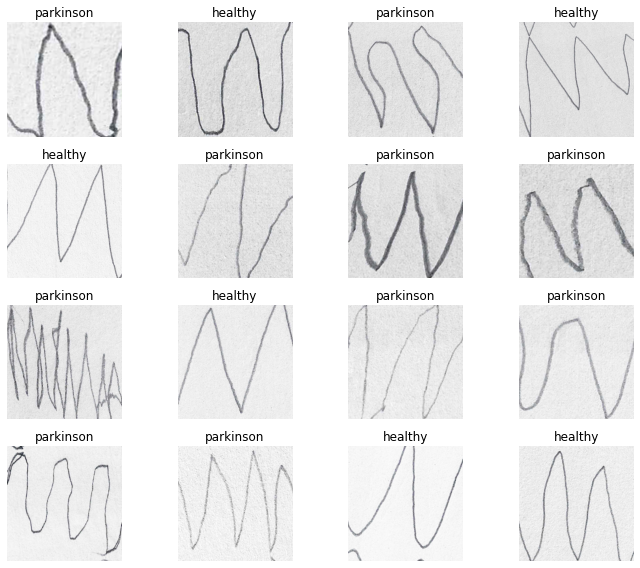

In [ ]:
data_spiral.show_batch(rows=4, figsize=(10,8))

In [ ]:
spiral = pd.read_csv('./drive/My Drive/뇌 및 머신러닝/spiral drawings.csv')
wave = pd.read_csv('./drive/My Drive/뇌 및 머신러닝/wave drawings.csv')
wave

,NAME,TYPE,COHORT
0,V01HO01,wave,healthy
1,V01HO02,wave,healthy
2,V01HO03,wave,healthy
3,V02HO01,wave,healthy
4,V02HO02,wave,healthy
...,...,...,...
97,V14PO02,wave,PD
98,V14PO03,wave,PD
99,V15PO01,wave,PD
100,V15PO02,wave,PD


In [ ]:
wave = wave.replace('healthy',0)
wave = wave.replace('PD',1)
wave

,NAME,TYPE,COHORT
0,V01HO01,wave,0
1,V01HO02,wave,0
2,V01HO03,wave,0
3,V02HO01,wave,0
4,V02HO02,wave,0
...,...,...,...
97,V14PO02,wave,1
98,V14PO03,wave,1
99,V15PO01,wave,1
100,V15PO02,wave,1


In [ ]:
df = wave.drop('COHORT',axis=1)
df2 = wave['COHORT']
x_train, x_test, y_train, y_test = train_test_split(df,df2,test_size=0.2)
len(x_train), len(x_test), len(y_train), len(y_test)

(81, 21, 81, 21)

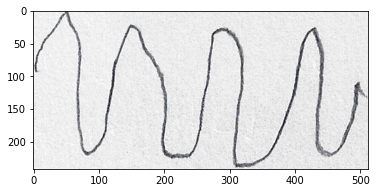

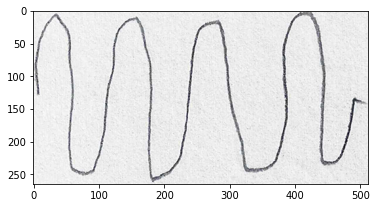

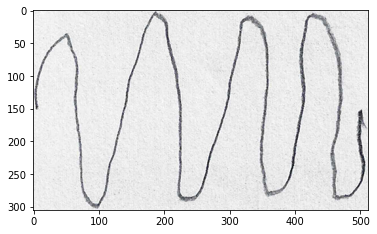

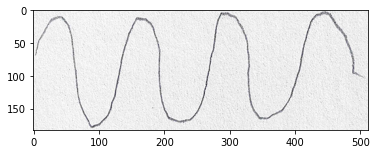

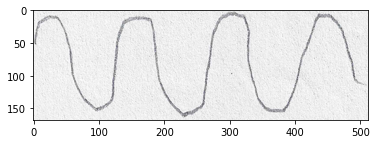

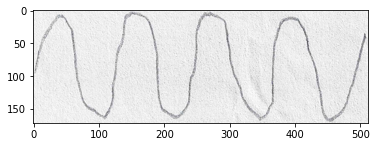

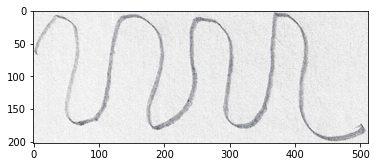

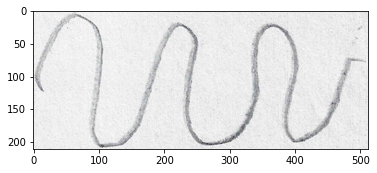

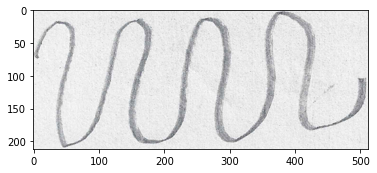

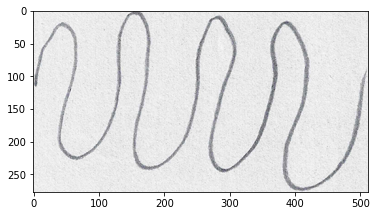

In [ ]:
name2 = wave['NAME']
for i in name2[0:10]:
    img = mpimg.imread('./drive/My Drive/뇌 및 머신러닝/wave/healthy/{0}.png'.format(i))
    # img = cv2.imread('./train_images/{0}.png'.format(i), cv2.IMREAD_UNCHANGED)
    plt.imshow(img)
    plt.show()
    # cv2.imwrite('gray', image)
    # cv2.imshow('gray',image)
#     
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
wave

,NAME,TYPE,COHORT
0,V01HO01,wave,0
1,V01HO02,wave,0
2,V01HO03,wave,0
3,V02HO01,wave,0
4,V02HO02,wave,0
...,...,...,...
97,V14PO02,wave,1
98,V14PO03,wave,1
99,V15PO01,wave,1
100,V15PO02,wave,1


In [ ]:
class WaveData(Dataset):
    def __init__(self,csv_file,transform):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        img_name = os.path.join('./drive/My Drive/뇌 및 머신러닝/wave/', self.data.loc[idx,'NAME'] + '.png')
        image = cv2.imread(img_name)
        image=Image.fromarray(image) 
        image = self.transform(image)
        label = torch.tensor(wave.loc[idx,'COHORT'])
        return {'image': image,
                'labels': label}

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [ ]:
Dataset2 = WaveData(csv_file='./drive/My Drive/뇌 및 머신러닝/wave drawings.csv' ,transform = train_transform)
train_wave_set, test_wave_set = torch.utils.data.random_split(Dataset2,[81,21])
train_wave_loader = torch.utils.data.DataLoader(train_wave_set,
                                          shuffle=True, num_workers=0,drop_last=True)
test_wave_loader = torch.utils.data.DataLoader(test_wave_set,
                                          shuffle=True, num_workers=0,drop_last=True)
train_wave_set[1]

{'image': tensor([[[0.9490, 0.9294, 0.9529,  ..., 0.9216, 0.8980, 0.8980],
          [0.9294, 0.9333, 0.9373,  ..., 0.9216, 0.9373, 0.8980],
          [0.9412, 0.8980, 0.8980,  ..., 0.8627, 0.9216, 0.8980],
          ...,
          [0.9412, 0.9255, 0.9294,  ..., 0.8941, 0.9059, 0.8980],
          [0.9255, 0.9176, 0.9373,  ..., 0.9020, 0.8549, 0.9059],
          [0.9569, 0.9412, 0.9137,  ..., 0.8941, 0.8980, 0.9333]],
 
         [[0.9490, 0.9294, 0.9529,  ..., 0.9216, 0.8980, 0.8980],
          [0.9294, 0.9333, 0.9373,  ..., 0.9216, 0.9373, 0.8980],
          [0.9412, 0.8980, 0.8980,  ..., 0.8627, 0.9216, 0.8980],
          ...,
          [0.9412, 0.9255, 0.9294,  ..., 0.8941, 0.9059, 0.8980],
          [0.9255, 0.9176, 0.9373,  ..., 0.9020, 0.8549, 0.9059],
          [0.9569, 0.9412, 0.9137,  ..., 0.8941, 0.8980, 0.9333]],
 
         [[0.9490, 0.9294, 0.9529,  ..., 0.9216, 0.8980, 0.8980],
          [0.9294, 0.9333, 0.9373,  ..., 0.9216, 0.9373, 0.8980],
          [0.9412, 0.8980, 0.89

In [ ]:
test_wave_set[1]

{'image': tensor([[[0.9451, 0.9490, 0.9529,  ..., 0.9255, 0.9216, 0.9412],
          [0.9216, 0.9529, 0.9647,  ..., 0.8902, 0.9098, 0.9412],
          [0.9294, 0.9294, 0.9373,  ..., 0.9216, 0.9059, 0.9216],
          ...,
          [0.9294, 0.9216, 0.9294,  ..., 0.9333, 0.9020, 0.9020],
          [0.9333, 0.9294, 0.9373,  ..., 0.9373, 0.9294, 0.9255],
          [0.9490, 0.9451, 0.9569,  ..., 0.9490, 0.9529, 0.9333]],
 
         [[0.9451, 0.9490, 0.9529,  ..., 0.9255, 0.9216, 0.9412],
          [0.9216, 0.9529, 0.9647,  ..., 0.8902, 0.9098, 0.9412],
          [0.9294, 0.9294, 0.9373,  ..., 0.9216, 0.9059, 0.9216],
          ...,
          [0.9294, 0.9216, 0.9294,  ..., 0.9333, 0.9020, 0.9020],
          [0.9333, 0.9294, 0.9373,  ..., 0.9373, 0.9294, 0.9255],
          [0.9490, 0.9451, 0.9569,  ..., 0.9490, 0.9529, 0.9333]],
 
         [[0.9451, 0.9490, 0.9529,  ..., 0.9255, 0.9216, 0.9412],
          [0.9216, 0.9529, 0.9647,  ..., 0.8902, 0.9098, 0.9412],
          [0.9294, 0.9294, 0.93

## Wave VGG19

In [ ]:
VGG19 = torchvision.models.vgg19(pretrained = True)
device2 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = VGG19.to(device2)
learning_rate = 0.001
num_epoch = 10
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer,step_size=10)
device2

device(type='cuda', index=0)

In [ ]:
loss_arr = []
# tk0 = tqdm(train_loader, total=int(len(train_loader)))
for i in range(num_epoch):
    scheduler.step()
    model.train()
    for j,batch in enumerate(train_wave_loader):
        x = batch['image'].to(device2)
        y = batch['labels'].to(device2)
        
        optimizer.zero_grad()
        output = model.forward(x) 
        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()
        
        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())           

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


tensor(9.5149, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1663, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6719, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4296, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8838, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7085, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5101, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3869, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7985, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4098, device='cuda:0', grad_fn=<NllLossBackward>)


Text(0.5, 1.0, 'VGG19 Wave Loss Graph')

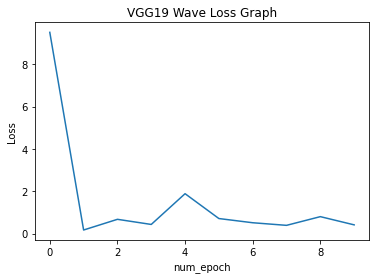

In [ ]:
plt.plot(loss_arr)
plt.xlabel('num_epoch')
plt.ylabel('Loss')
plt.title('VGG19 Wave Loss Graph')

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for b,di in enumerate(test_wave_loader):
        x_ = di['image'].to(device2)
        y_ = di['labels'].to(device2)
        
        output = model.forward(x_)
        _,output_index = torch.max(output,1)
        
        total += y_.size(0)
        correct += (output_index == y_).sum().float()
        
    print('Accuracy of Test Data: {}'.format(100*correct/total))

Accuracy of Test Data: 71.42857360839844


## Wave GoogleNet

In [ ]:
googlenet = torchvision.models.googlenet(pretrained = True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = googlenet.to(device)
learning_rate = 0.001
num_epoch = 10
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer,step_size=10)
device

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


device(type='cuda', index=0)

In [ ]:
loss_arr = []
# tk0 = tqdm(train_loader, total=int(len(train_loader)))
for i in range(num_epoch):
    scheduler.step()
    model.train()
    for j,batch in enumerate(train_wave_loader):
        x = batch['image'].to(device)
        y = batch['labels'].to(device)
        
        optimizer.zero_grad()
        output = model.forward(x) 
        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()
        
        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())           

tensor(7.3501, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7294, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8181, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4098, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2621, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1391, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.2578, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3976, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2218, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7765, device='cuda:0', grad_fn=<NllLossBackward>)


Text(0.5, 1.0, 'GoogleNet Wave Loss Graph')

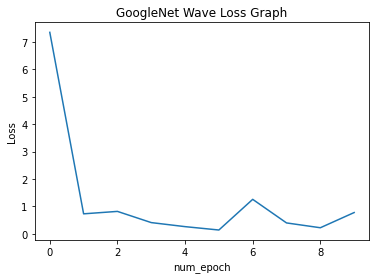

In [ ]:
plt.plot(loss_arr)
plt.xlabel('num_epoch')
plt.ylabel('Loss')
plt.title('GoogleNet Wave Loss Graph')

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for b,di in enumerate(test_wave_loader):
        x_ = di['image'].to(device)
        y_ = di['labels'].to(device)
        
        output = model.forward(x_)
        _,output_index = torch.max(output,1)
        
        total += y_.size(0)
        correct += (output_index == y_).sum().float()
        
    print('Accuracy of Test Data: {}'.format(100*correct/total))

Accuracy of Test Data: 71.42857360839844


## Wave Resnet50

In [ ]:
resnet50 = torchvision.models.resnet50(pretrained = True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = resnet50.to(device)
learning_rate = 0.01
num_epoch = 10
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer,step_size=10)
device

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


device(type='cuda', index=0)

In [ ]:
loss_arr = []
# tk0 = tqdm(train_loader, total=int(len(train_loader)))
for i in range(num_epoch):
    scheduler.step()
    model.train()
    for j,batch in enumerate(train_wave_loader):
        x = batch['image'].to(device)
        y = batch['labels'].to(device)
        
        optimizer.zero_grad()
        output = model.forward(x) 
        loss = loss_func(output,y)
        loss.backward()
        optimizer.step()
        
        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())     

tensor(0.6470, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6577, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6822, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7002, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6609, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7473, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6561, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6463, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.8188, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.7514, device='cuda:0', grad_fn=<NllLossBackward>)


Text(0.5, 1.0, 'ResNet50 Wave Loss Graph')

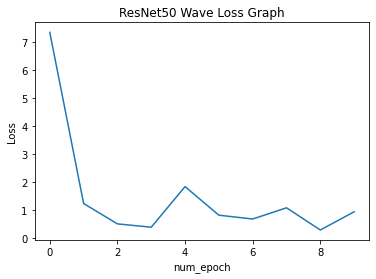

In [ ]:
plt.plot(loss_arr)
plt.xlabel('num_epoch')
plt.ylabel('Loss')
plt.title('ResNet50 Wave Loss Graph')

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for b,di in enumerate(test_wave_loader):
        x_ = di['image'].to(device)
        y_ = di['labels'].to(device)
        
        output = model.forward(x_)
        _,output_index = torch.max(output,1)
        
        total += y_.size(0)
        correct += (output_index == y_).sum().float()
        
    print('Accuracy of Test Data: {}'.format(100*correct/total))

Accuracy of Test Data: 61.904762268066406
